# Predicting, simulating, and correcting sidewall angle

## Introduction

This notebook example provides a guide to predicting and simulating the effective refractive index of a waveguide with an angled sidewall. While sidewall angle is an effect of the etching process, and we cannot correct the structure with lithographic techniques, we can adjust the dimensions of the design to achieve a similar effective structure. This tutorial adapts and extends the [mode solver example](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/) from [Tidy3D](https://www.flexcompute.com/tidy3d) and is organized into the three following sections:
1. Setup a nominal simulation of a silicon nitride (SiN) waveguide with Tidy3D's `ModeSolver`.
2. Predict and compare the structures using PreFab.
3. Simulate and evaluate the difference in effective index for the nominal, predicted, and corrected structures.

We first import the necessary libraries:

In [1]:
import cv2
import matplotlib.pylab as plt
import numpy as np
import tidy3d as td
from tidy3d.constants import C_0
from tidy3d.plugins.mode import ModeSolver

import prefab as pf

## Nominal simulation

We start with a simple nominal mode simulation of a SiN waveguide with Tidy3D's `ModeSolver`. We will visualize the results in the comparison at the end.

In [2]:
# size of simulation domain
Lx, Ly, Lz = 2, 4, 2
dl = 0.01

# waveguide information
wg_width = 0.8
wg_height = 0.4
Air = td.Medium(permittivity=1.0**2)
SiN = td.Medium(permittivity=2.0**2)

# central frequency
wvl_um = 1.55
freq0 = C_0 / wvl_um
fwidth = freq0 / 6

# run_time in ps
run_time = 1e-12

# uniform grid specification
grid_spec = td.GridSpec.uniform(dl=dl)

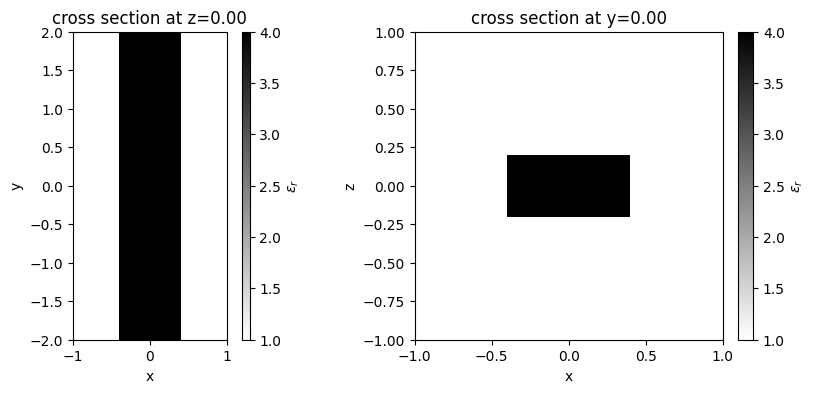

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(wg_width, td.inf, wg_height)),
    medium=td.Medium(permittivity=SiN.permittivity),
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    structures=[waveguide],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sim.plot_eps(z=0, ax=axs[0])
sim.plot_eps(y=0, ax=axs[1])
plt.show()

In [4]:
plane = td.Box(center=(0, 0, 0), size=(2, 0, 2))

mode_spec = td.ModeSpec(
    num_modes=2,
    target_neff=1.45,
)

num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data = mode_solver.solve()

10:21:54 EST WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

## PreFab prediction

Next we use PreFab to predict how the nominal waveguide will actually be fabricated. Even for this simple waveguide structure, the fabrication process introduces imperfections - most notably non-vertical sidewalls. While other fabrication effects like sidewall roughness, layer thickness variation, and etch depth variation can be simulated, we'll focus only on sidewall angle for this example.

First, we'll convert the simulation structure to an array for PreFab to process. We'll do this step-by-step to understand the process, though it could be abstracted into a function.

<Axes: xlabel='x (nm)', ylabel='y (nm)'>

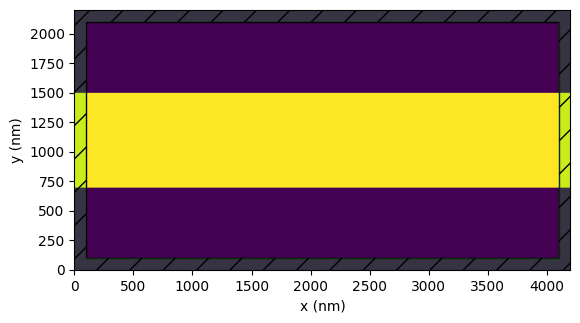

In [5]:
# convert the simulation structure to an ndarray with 1 nm resolution
X = np.arange(
    sim.bounds[0][0],
    sim.bounds[1][0],
    0.001,
)
Y = np.arange(
    sim.bounds[0][1],
    sim.bounds[1][1],
    0.001,
)
Z = np.array([0])
grid = td.Grid(boundaries=td.Coords(x=X, y=Y, z=Z))
eps = np.real(sim.epsilon_on_grid(grid=grid, coord_key="boundaries", freq=freq0).values)
eta = (eps.min() + eps.max()) / 2
device_array = pf.geometry.binarize_hard(device_array=eps, eta=eta)[:, :, 0]

# create a device object from the ndarray
buffer_spec = pf.BufferSpec(
    mode={"top": "edge", "bottom": "edge", "left": "edge", "right": "edge"},
    thickness={"top": 100, "bottom": 100, "left": 100, "right": 100},
)
device = pf.Device(
    device_array=device_array,
    buffer_spec=buffer_spec,
)
device.plot()

Next we run the prediction for the SiN process from [Applied Nanotools](https://www.appliednt.com/). We also run the correction and then the prediction again to get the final, best outcome. There is not much to be observed at this level of scale, other than the sidewall segment, but we will take a closer look in the next section.

> **Note:** If you would like to see models of other fabrication processes, please contact us at [support@prefabphotonics.com](mailto:support@prefabphotonics.com) to request them. Current models are listed [here](https://docs.prefabphotonics.com/models/).

We set `gpu=True` to speed up the prediction. Note that GPU predictions have a longer startup time, so smaller devices will run faster on the CPU (`gpu=False`). We set `binarize=True` to capture the most likely fabrication outcome, but we can also set `binarize=False` to get the full range of possible outcomes (more on this in a future notebook about prediction uncertainty and fabrication variability).

Prediction: 100%|██████████████████████████████| 100/100 [00:01<00:00, 51.37%/s]


Text(0.5, 1.0, 'Corrected Outcome')

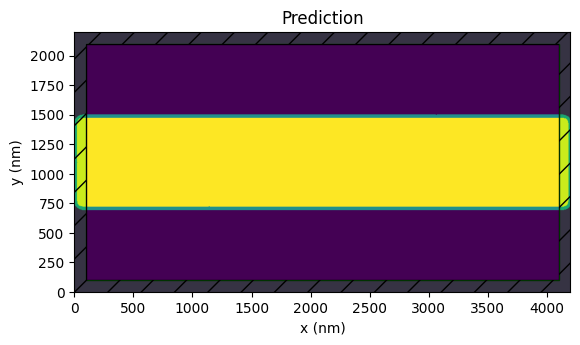

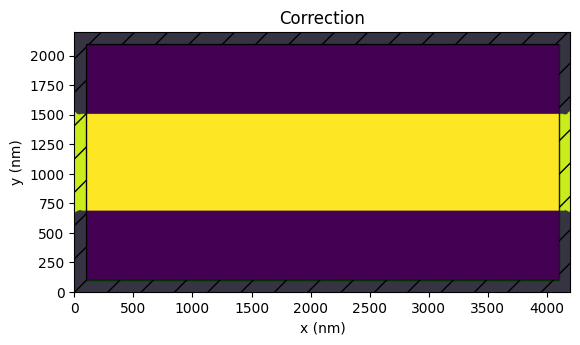

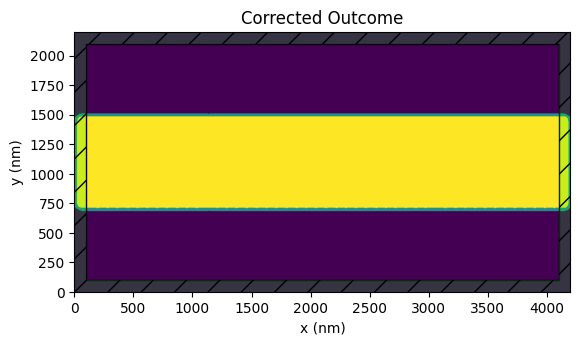

In [6]:
MODEL_NAME = "ANT_SiN"
use_gpu = True

prediction = device.predict(model=pf.models[MODEL_NAME], binarize=True, gpu=use_gpu)
ax1 = prediction.plot()
ax1.set_title("Prediction")
correction = device.correct(model=pf.models[MODEL_NAME], binarize=True, gpu=use_gpu)
ax2 = correction.plot()
ax2.set_title("Correction")
outcome = correction.predict(model=pf.models[MODEL_NAME], binarize=True, gpu=use_gpu)
ax3 = outcome.plot()
ax3.set_title("Corrected Outcome")

## Simulation of sidewall angle

PreFab represents sidewall angles using two layers: the bottom and top edges of the waveguide. We'll convert this 2D prediction into a 3D representation using a simple linear profile, though real sidewalls can have curved or more complex features.

In [7]:
resolution_3d = 0.3  # to reduce the array size for faster computation


def to_3d(prediction):
    thickness_nm = wg_height * 1000

    prediction_array = prediction.to_ndarray()

    new_shape = tuple(int(dim * resolution_3d) for dim in prediction_array.shape[:2])
    scaled_thickness = max(int(thickness_nm * resolution_3d), 2)

    bottom_layer = cv2.resize(
        prediction_array[:, :, 0],
        (new_shape[1], new_shape[0]),
        interpolation=cv2.INTER_LINEAR,
    )
    top_layer = cv2.resize(
        prediction_array[:, :, -1],
        (new_shape[1], new_shape[0]),
        interpolation=cv2.INTER_LINEAR,
    )

    bottom_layer = (bottom_layer > 0.5).astype(np.uint8)
    top_layer = (top_layer > 0.5).astype(np.uint8)

    dt_bottom = cv2.distanceTransform(
        bottom_layer, cv2.DIST_L2, 5
    ) - cv2.distanceTransform(1 - bottom_layer, cv2.DIST_L2, 5)
    dt_top = cv2.distanceTransform(top_layer, cv2.DIST_L2, 5) - cv2.distanceTransform(
        1 - top_layer, cv2.DIST_L2, 5
    )

    weights = np.linspace(0, 1, scaled_thickness)
    prediction_3d = np.zeros((new_shape[0], new_shape[1], scaled_thickness))

    for i, w in enumerate(weights):
        dt_interp = (1 - w) * dt_bottom + w * dt_top
        prediction_3d[:, :, i] = 1 / (1 + np.exp(-dt_interp))

    return prediction_3d


prediction_3d = to_3d(prediction)
outcome_3d = to_3d(outcome)

Next we'll convert the 3D prediction into a new Tidy3D simulation.

In [8]:
def prediction_to_sim(prediction_3d, sim_base):
    convert_scale = 1000 * resolution_3d

    X = np.linspace(
        sim.bounds[0][0],
        sim.bounds[1][0],
        prediction_3d.shape[0],
    )
    Y = np.linspace(
        sim.bounds[0][1],
        sim.bounds[1][1],
        prediction_3d.shape[1],
    )
    Z = np.linspace(
        -prediction_3d.shape[2] / 2 / convert_scale,
        prediction_3d.shape[2] / 2 / convert_scale,
        prediction_3d.shape[2],
    )

    eps_array = prediction_3d * (SiN.permittivity - Air.permittivity) + Air.permittivity
    eps_dataset = td.SpatialDataArray(eps_array, coords=dict(x=X, y=Y, z=Z))
    medium = td.CustomMedium(permittivity=eps_dataset)
    wg_p = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, wg_height), attrs={}),
        medium=medium,
        attrs={},
    )

    return sim_base.copy(update=dict(structures=[wg_p]))


sim_p = prediction_to_sim(prediction_3d, sim)
sim_o = prediction_to_sim(outcome_3d, sim)

Observing the cross-section of the simulation, we can see that the prediction indeed has a sidewall angle, where the top edge is narrower than the nominal width. The corrected waveguide still has angled sidewalls, as we cannot structurally correct for sidewall angle with lithographic OPC techniques, but its full width at half maximum height matches the nominal waveguide, resulting in the same effective index (as we'll see in the next section).

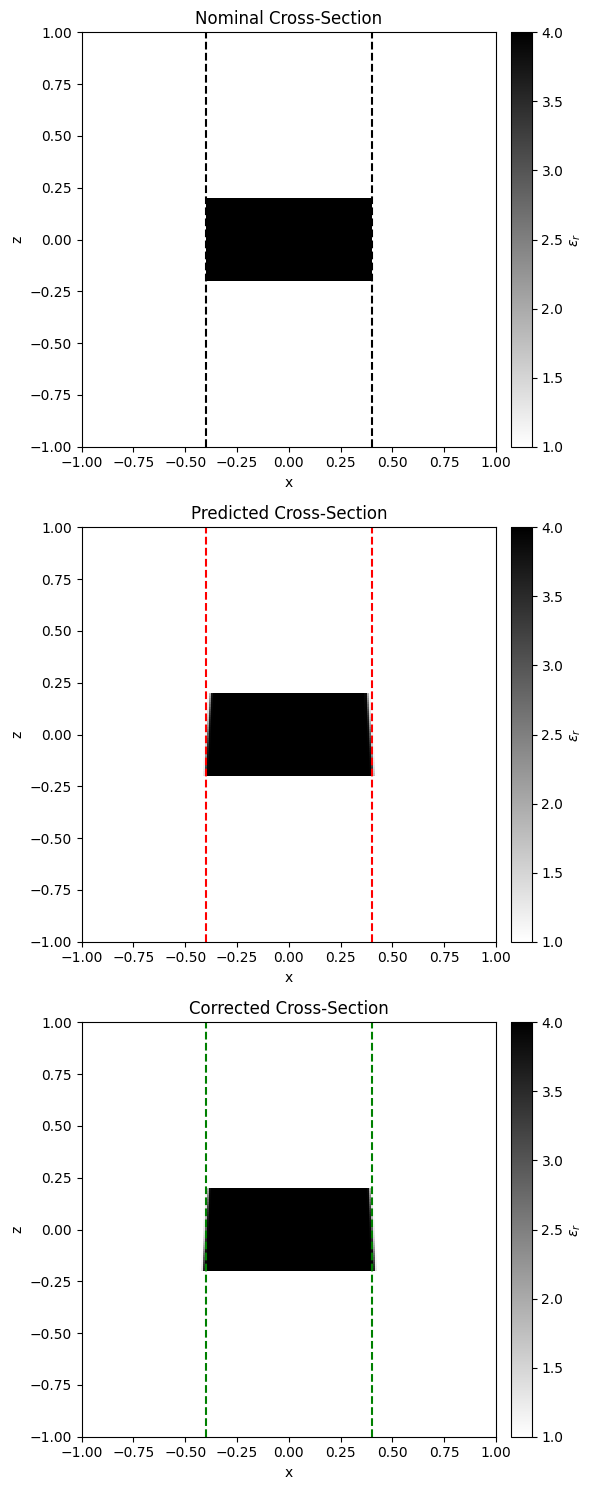

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

sim.plot_eps(y=0, ax=axs[0])
axs[0].axvline(x=-wg_width / 2, color="k", linestyle="--")
axs[0].axvline(x=wg_width / 2, color="k", linestyle="--")
axs[0].set_title("Nominal Cross-Section")

sim_p.plot_eps(y=0, ax=axs[1])
axs[1].axvline(x=-wg_width / 2, color="r", linestyle="--")
axs[1].axvline(x=wg_width / 2, color="r", linestyle="--")
axs[1].set_title("Predicted Cross-Section")

sim_o.plot_eps(y=0, ax=axs[2])
axs[2].axvline(x=-wg_width / 2, color="g", linestyle="--")
axs[2].axvline(x=wg_width / 2, color="g", linestyle="--")
axs[2].set_title("Corrected Cross-Section")

plt.tight_layout()
plt.show()

Run the mode solver again!

In [14]:
mode_solver_p = ModeSolver(
    simulation=sim_p,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data_p = mode_solver_p.solve()

mode_solver_o = ModeSolver(
    simulation=sim_o,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data_o = mode_solver_o.solve()

Here we see how the effective index is reduced for the predicted waveguide, which makes sense as the volume of the SiN is reduced. The corrected waveguide has the same effective index as the nominal waveguide, as expected. With the relatively low refractive index of SiN, the effective index is only reduced by a few percent, but this effect can be more significant for silicon and other high-index materials.

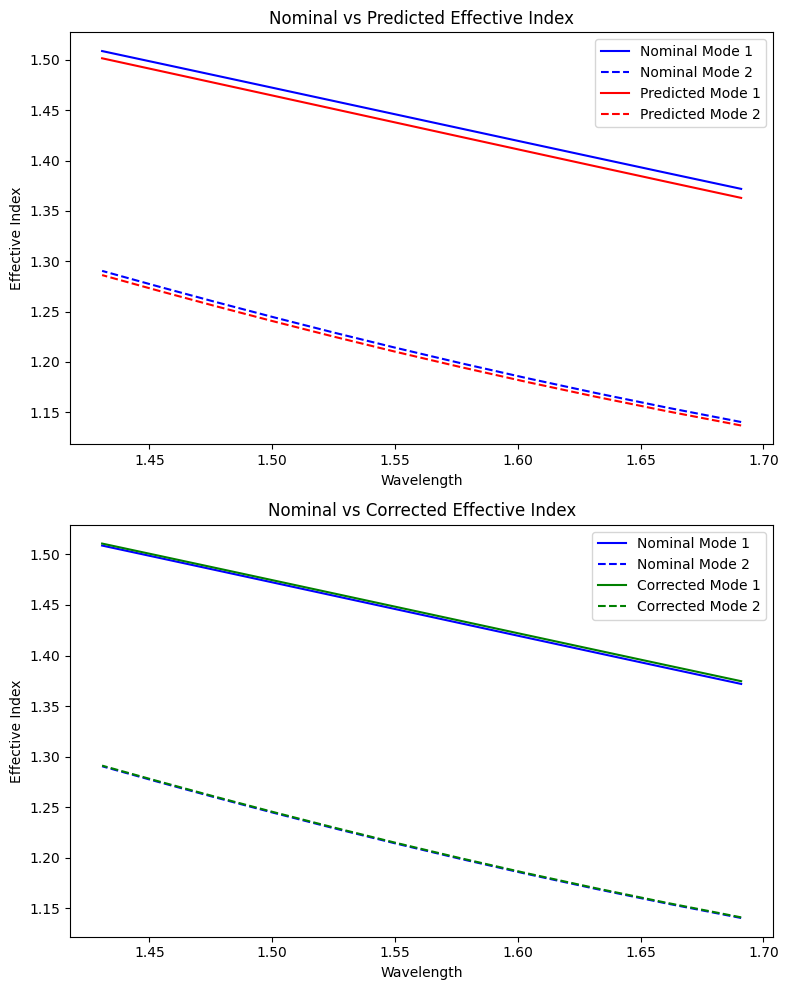

In [17]:
lams = C_0 / freqs

fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# nominal and predicted
axs[0].plot(lams, mode_data.n_eff[:, 0], "b-", label="Nominal Mode 1")
axs[0].plot(lams, mode_data.n_eff[:, 1], "b--", label="Nominal Mode 2")
axs[0].plot(lams, mode_data_p.n_eff[:, 0], "r-", label="Predicted Mode 1")
axs[0].plot(lams, mode_data_p.n_eff[:, 1], "r--", label="Predicted Mode 2")
axs[0].legend()
axs[0].set_title("Nominal vs Predicted Effective Index")
axs[0].set_xlabel("Wavelength")
axs[0].set_ylabel("Effective Index")

# nominal and corrected outcome
axs[1].plot(lams, mode_data.n_eff[:, 0], "b-", label="Nominal Mode 1")
axs[1].plot(lams, mode_data.n_eff[:, 1], "b--", label="Nominal Mode 2")
axs[1].plot(lams, mode_data_o.n_eff[:, 0], "g-", label="Corrected Mode 1")
axs[1].plot(lams, mode_data_o.n_eff[:, 1], "g--", label="Corrected Mode 2")
axs[1].legend()
axs[1].set_title("Nominal vs Corrected Effective Index")
axs[1].set_xlabel("Wavelength")
axs[1].set_ylabel("Effective Index")

plt.tight_layout()
plt.show()

That's it for this simple tutorial. We see how sidewall angle can be predicted and corrected with PreFab. The same process can be applied to complex device designs with many features. When applying this to your own designs, you may observe that the angle varies by feature type - an interesting process characteristic - but the same correction approach still applies.